In [3]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from datetime import timedelta

In [4]:
zip_path = r"C:\Users\maxim\Downloads\mimic-iii-clinical-database-1.4.zip"

# ============================================================================
# LOAD ICUSTAYS DATA
# ============================================================================
print("Loading ICUSTAYS...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open('mimic-iii-clinical-database-1.4/ICUSTAYS.csv.gz') as gz_file:
        icustays = pd.read_csv(gz_file, compression='gzip')
        # Convert INTIME to datetime
        icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])
        # Calculate first 48 hours end time
        icustays['FIRST_48H_END'] = icustays['INTIME'] + timedelta(days=2)

print(f"Loaded {len(icustays)} ICU stays")

# ============================================================================
# LOAD OUTPUTEVENTS DATA
# ============================================================================
print("Loading OUTPUTEVENTS...")

# Define all urine output ITEMIDs
urine_itemids = [
    # CareVue ITEMIDs
    40055,  # Urine Out Foley
    43175,  # Urine .
    40069,  # Urine Out Void
    40094,  # Urine Out Condom Cath
    40715,  # Urine Out Suprapubic
    40473,  # Urine Out IleoConduit
    40085,  # Urine Out Incontinent
    40057,  # Urine Out Rt Nephrostomy
    40056,  # Urine Out Lt Nephrostomy
    40405,  # Urine Out Other
    40428,  # Urine Out Straight Cath
    40086,  # Urine Out Incontinent
    40096,  # Urine Out Ureteral Stent #1
    40651,  # Urine Out Ureteral Stent #2
    # MetaVision ITEMIDs
    226559, # Foley
    226560, # Void
    226561, # Condom Cath
    226584, # Ileoconduit
    226563, # Suprapubic
    226564, # R Nephrostomy
    226565, # L Nephrostomy
    226567, # Straight Cath
    226557, # R Ureteral Stent
    226558, # L Ureteral Stent
    227488, # GU Irrigant Volume In
    227489  # GU Irrigant/Urine Volume Out
]

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open('mimic-iii-clinical-database-1.4/OUTPUTEVENTS.csv.gz') as gz_file:
        chunk_iterator = pd.read_csv(gz_file, compression='gzip', chunksize=1_000_000)
        
        urine_chunks = []
        for i, chunk in enumerate(chunk_iterator):
            print(f"Processing OUTPUTEVENTS chunk {i+1}...")
            # Filter for urine output ITEMIDs only
            filtered = chunk[chunk['ITEMID'].isin(urine_itemids)]
            if not filtered.empty:
                urine_chunks.append(filtered)
        
        outputevents_urine = pd.concat(urine_chunks, ignore_index=True)

print(f"Loaded {len(outputevents_urine)} urine output measurements")


Loading ICUSTAYS...
Loaded 61532 ICU stays
Loading OUTPUTEVENTS...
Processing OUTPUTEVENTS chunk 1...
Processing OUTPUTEVENTS chunk 2...
Processing OUTPUTEVENTS chunk 3...
Processing OUTPUTEVENTS chunk 4...
Processing OUTPUTEVENTS chunk 5...
Loaded 3400763 urine output measurements


In [14]:
# ============================================================================
# MERGE WITH ICUSTAYS AND FILTER FOR FIRST 48 HOURS
# ============================================================================
print("Merging with ICUSTAYS and filtering for first 48 hours...")

# Convert CHARTTIME to datetime
outputevents_urine['CHARTTIME'] = pd.to_datetime(outputevents_urine['CHARTTIME'])

# Merge with icustays to get INTIME and FIRST_48H_END
urine_with_times = outputevents_urine.merge(
    icustays[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'INTIME', 'FIRST_48H_END']],
    on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'],
    how='inner'
)

# Filter for measurements within first 48 hours
first_48h_urine = urine_with_times[
    (urine_with_times['CHARTTIME'] >= urine_with_times['INTIME']) &
    (urine_with_times['CHARTTIME'] <= urine_with_times['FIRST_48H_END'])
].copy()

print(f"Filtered to {len(first_48h_urine)} measurements in first 48 hours")

# ============================================================================
# APPLY GU IRRIGANT ADJUSTMENT AND CALCULATE TOTAL URINE OUTPUT
# ============================================================================
print("Calculating urine output...")

# Apply the special logic for GU Irrigant (ITEMID 227488)
# If it's GU Irrigant and value > 0, multiply by -1
first_48h_urine['ADJUSTED_VALUE'] = first_48h_urine.apply(
    lambda row: -1 * row['VALUE'] if (row['ITEMID'] == 227488 and row['VALUE'] > 0) else row['VALUE'],
    axis=1
)

# Group by ICU stay and sum the adjusted values
urine_output_first_48h = first_48h_urine.groupby(
    ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID']
).agg({'ADJUSTED_VALUE': 'sum'}).reset_index()

# Rename the column to match the SQL output
urine_output_first_48h.rename(columns={'ADJUSTED_VALUE': 'URINE_OUTPUT'}, inplace=True)

# Sort by identifiers
urine_output_first_48h.sort_values(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'], inplace=True)

print(f"\nFinal result: {len(urine_output_first_48h)} ICU stays with urine output data")

urine_output_first_48h.head(10)

Merging with ICUSTAYS and filtering for first 48 hours...
Filtered to 1325277 measurements in first 48 hours
Calculating urine output...

Final result: 53590 ICU stays with urine output data


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,URINE_OUTPUT
0,3,145834.0,211552.0,1697.0
1,4,185777.0,294638.0,3050.0
2,6,107064.0,228232.0,3565.0
3,8,159514.0,262299.0,150.0
4,9,150750.0,220597.0,3515.0
5,10,184167.0,288409.0,149.0
6,11,194540.0,229441.0,1600.0
7,12,112213.0,232669.0,6110.0
8,13,143045.0,263738.0,1375.0
9,17,161087.0,257980.0,2075.0


In [15]:
df = pd.read_csv('hr_rr_t_ag_dbp_sbp_age_gender_mortality_elixhauser_hem_urea.csv')

df.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,MORTALITY_INHOSPITAL,HR_MEAN,HR_MEDIAN,HR_STD,HR_MIN,HR_MAX,HR_COUNT,...,HEM_STD,HEM_MIN,HEM_MAX,HEM_COUNT,UREA_MEAN,UREA_MEDIAN,UREA_STD,UREA_MIN,UREA_MAX,UREA_COUNT
0,268,110404,280836,1,103.101695,98.0,25.040447,73.0,190.0,59.0,...,1.087592,9.5,12.8,8.0,57.20,61.0,17.725061,24.0,83.0,10.0
1,269,106296,206613,0,117.653846,116.0,15.438537,72.0,147.0,52.0,...,1.353514,11.2,14.6,5.0,8.00,8.0,1.897367,6.0,11.0,6.0
2,270,188028,220345,0,56.875000,60.0,6.499084,32.0,70.0,64.0,...,0.590903,13.6,14.9,4.0,28.00,28.5,1.414214,26.0,29.0,4.0
3,274,130546,254851,0,92.716981,93.0,11.774120,63.0,116.0,53.0,...,1.252664,12.3,14.9,4.0,12.25,11.5,2.629956,10.0,16.0,4.0
4,275,129886,219649,1,59.933333,59.0,8.632391,49.0,90.0,45.0,...,2.232487,11.1,17.0,6.0,32.00,28.0,9.695360,24.0,49.0,6.0


In [17]:
# Merge Hemoglobin features to feature df
final_df_with_urine_output = df.merge(
    urine_output_first_48h[['ICUSTAY_ID', 'URINE_OUTPUT']], 
    on='ICUSTAY_ID', 
    how='left'
)

In [19]:
final_df_with_urine_output.head(5)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,MORTALITY_INHOSPITAL,HR_MEAN,HR_MEDIAN,HR_STD,HR_MIN,HR_MAX,HR_COUNT,...,HEM_MIN,HEM_MAX,HEM_COUNT,UREA_MEAN,UREA_MEDIAN,UREA_STD,UREA_MIN,UREA_MAX,UREA_COUNT,URINE_OUTPUT
0,268,110404,280836,1,103.101695,98.0,25.040447,73.0,190.0,59.0,...,9.5,12.8,8.0,57.20,61.0,17.725061,24.0,83.0,10.0,380.0
1,269,106296,206613,0,117.653846,116.0,15.438537,72.0,147.0,52.0,...,11.2,14.6,5.0,8.00,8.0,1.897367,6.0,11.0,6.0,8290.0
2,270,188028,220345,0,56.875000,60.0,6.499084,32.0,70.0,64.0,...,13.6,14.9,4.0,28.00,28.5,1.414214,26.0,29.0,4.0,4405.0
3,274,130546,254851,0,92.716981,93.0,11.774120,63.0,116.0,53.0,...,12.3,14.9,4.0,12.25,11.5,2.629956,10.0,16.0,4.0,3450.0
4,275,129886,219649,1,59.933333,59.0,8.632391,49.0,90.0,45.0,...,11.1,17.0,6.0,32.00,28.0,9.695360,24.0,49.0,6.0,2335.0


In [20]:
final_df_with_urine_output['ICUSTAY_ID'].nunique()

21178

In [23]:
# Export df as csv
final_df_with_urine_output.to_csv('hr_rr_t_ag_dbp_sbp_age_gender_mortality_elixhauser_hem_urea_urine.csv', index = False)

In [24]:
x = pd.read_csv('hr_rr_t_ag_dbp_sbp_age_gender_mortality_elixhauser_hem_urea_urine.csv')

x.head(6)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,MORTALITY_INHOSPITAL,HR_MEAN,HR_MEDIAN,HR_STD,HR_MIN,HR_MAX,HR_COUNT,...,HEM_MIN,HEM_MAX,HEM_COUNT,UREA_MEAN,UREA_MEDIAN,UREA_STD,UREA_MIN,UREA_MAX,UREA_COUNT,URINE_OUTPUT
0,268,110404,280836,1,103.101695,98.0,25.040447,73.0,190.0,59.0,...,9.5,12.8,8.0,57.200000,61.0,17.725061,24.0,83.0,10.0,380.0
1,269,106296,206613,0,117.653846,116.0,15.438537,72.0,147.0,52.0,...,11.2,14.6,5.0,8.000000,8.0,1.897367,6.0,11.0,6.0,8290.0
2,270,188028,220345,0,56.875000,60.0,6.499084,32.0,70.0,64.0,...,13.6,14.9,4.0,28.000000,28.5,1.414214,26.0,29.0,4.0,4405.0
3,274,130546,254851,0,92.716981,93.0,11.774120,63.0,116.0,53.0,...,12.3,14.9,4.0,12.250000,11.5,2.629956,10.0,16.0,4.0,3450.0
4,275,129886,219649,1,59.933333,59.0,8.632391,49.0,90.0,45.0,...,11.1,17.0,6.0,32.000000,28.0,9.695360,24.0,49.0,6.0,2335.0
5,279,192224,204407,0,81.333333,82.0,7.944681,62.0,96.0,66.0,...,9.8,13.7,11.0,111.166667,117.5,18.852699,68.0,129.0,12.0,155.0


Correlation with MORTALITY_INHOSPITAL:
 MORTALITY_INHOSPITAL         1.000000
age_adj_comorbidity_score    0.214751
comorbidity_score            0.206490
AG_MEAN                      0.204531
AG_MEDIAN                    0.203589
AG_MAX                       0.180133
UREA_MAX                     0.176772
UREA_MEAN                    0.176580
UREA_MIN                     0.173704
UREA_MEDIAN                  0.173260
SYSBP_STD                    0.169159
AG_MIN                       0.157463
RR_MEAN                      0.142402
RR_MEDIAN                    0.134513
TEMP_STD                     0.127002
HR_MAX                       0.115573
AGE                          0.114018
RR_MAX                       0.098224
HR_STD                       0.093442
HR_MEAN                      0.091811
RR_MIN                       0.086036
HR_MEDIAN                    0.084977
UREA_STD                     0.075595
DIASBP_STD                   0.064822
AG_STD                       0.053301
SYSBP_MAX 

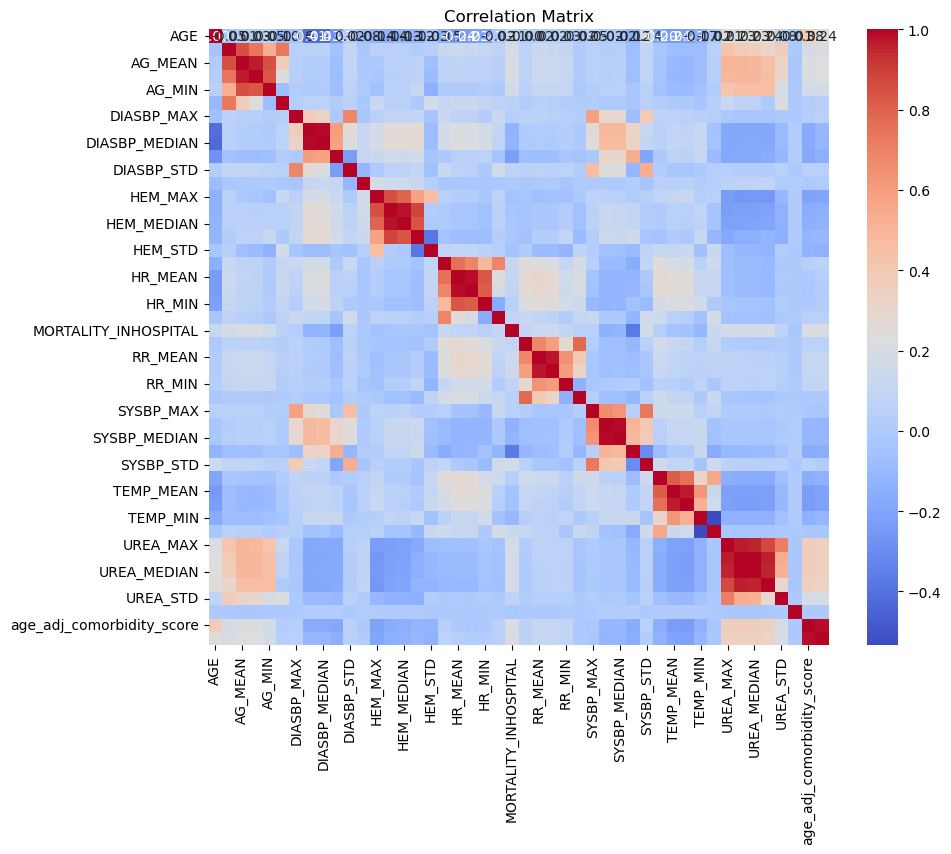

In [22]:
df_corr = final_df_with_urine_output.copy()

numeric_cols = df_corr.select_dtypes(include=[np.number]).columns.tolist()

# Exclude columns
id_cols = ['SUBJECT_ID', 'ICUSTAY_ID', 'HADM_ID', 'HR_COUNT', 'SYSBP_COUNT', 'DIASBP_COUNT', 'TEMP_COUNT', 'AG_COUNT', 'RR_COUNT', 'HEM_COUNT', 'UREA_COUNT']
numeric_cols = [col for col in numeric_cols if col not in id_cols]

# Sort alphabetically
numeric_cols = sorted(numeric_cols)

df_numeric = df_corr[numeric_cols]
corr_matrix = df_numeric.corr()

# Show correlation of features with target
target_corr = corr_matrix['MORTALITY_INHOSPITAL'].sort_values(ascending=False)
print("Correlation with MORTALITY_INHOSPITAL:\n", target_corr)

# Optional: Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

#### Conclusion:
Urine Output is not a good features (low correlation of -0.015)